In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("klemenko/kitti-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kitti-dataset


In [2]:
!pip install ultralytics opencv-python numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import os

# Root directory of the KITTI dataset
kitti_base_path = "/kaggle/input/kitti-dataset"

# Training images and labels
kitti_images_dir = os.path.join(kitti_base_path, "data_object_image_2/training/image_2")
kitti_labels_dir = os.path.join(kitti_base_path, "data_object_label_2/training/label_2")

# YOLO dataset directories
yolo_dataset_path = "yolo_dataset"
yolo_images_train = os.path.join(yolo_dataset_path, "images/train")
yolo_images_val = os.path.join(yolo_dataset_path, "images/val")
yolo_labels_train = os.path.join(yolo_dataset_path, "labels/train")
yolo_labels_val = os.path.join(yolo_dataset_path, "labels/val")

# Create directories
os.makedirs(yolo_images_train, exist_ok=True)
os.makedirs(yolo_images_val, exist_ok=True)
os.makedirs(yolo_labels_train, exist_ok=True)
os.makedirs(yolo_labels_val, exist_ok=True)

print("Directories set up correctly.")


Directories set up correctly.


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# KITTI class mapping
kitti_classes = {'Car': 0, 'Pedestrian': 1, 'Cyclist': 2}
num_classes = len(kitti_classes)

# Directories
kitti_images_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2"
kitti_labels_dir = "/kaggle/input/kitti-dataset/data_object_label_2/training/label_2"

# Parameters
img_size = 64  # size to resize cropped objects
max_images = 1000  # limit for testing

# Load data
X, y = [], []
image_files = sorted(os.listdir(kitti_images_dir))[:max_images]

for img_file in image_files:
    img_path = os.path.join(kitti_images_dir, img_file)
    label_path = os.path.join(kitti_labels_dir, img_file.replace('.png', '.txt'))

    image = cv2.imread(img_path)
    if image is None:
        continue

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_name = parts[0]
            if class_name not in kitti_classes:
                continue
            bbox = list(map(float, parts[4:8]))  # [xmin, ymin, xmax, ymax]
            xmin, ymin, xmax, ymax = map(int, bbox)
            obj = image[ymin:ymax, xmin:xmax]
            if obj.size == 0:
                continue
            obj = cv2.resize(obj, (img_size, img_size))
            X.append(obj)
            y.append(kitti_classes[class_name])

X = np.array(X, dtype="float32") / 255.0
y = to_categorical(y, num_classes)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

# Evaluation
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(kitti_classes.keys())))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7972 - loss: 0.4959 - val_accuracy: 0.8589 - val_loss: 0.4167
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8964 - loss: 0.2656 - val_accuracy: 0.9179 - val_loss: 0.2295
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9399 - loss: 0.1568 - val_accuracy: 0.9278 - val_loss: 0.1973
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9511 - loss: 0.1166 - val_accuracy: 0.9300 - val_loss: 0.2124
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9654 - loss: 0.1042 - val_accuracy: 0.9289 - val_loss: 0.2378
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report:
              precision    recall  f1-score   support

         Car       0.98      0.97      0.97       746
  Pedestrian       0.70      0.90      0.79       120
     Cyclist       0.86      0.40      0.54        48

    accuracy                           0.93       914
   macro avg       0.85      

In [5]:
import shutil
import numpy as np
from tqdm import tqdm

# KITTI class labels
kitti_classes = ["Car", "Pedestrian", "Cyclist", "Truck", "Van"]

def convert_kitti_to_yolo(label_file, split="train"):
    with open(os.path.join(kitti_labels_dir, label_file), "r") as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        obj_class = parts[0]
        if obj_class in kitti_classes:
            x_min, y_min, x_max, y_max = map(float, parts[4:8])
            width = 1242  # Adjust if your image size differs
            height = 375

            x_center = ((x_min + x_max) / 2) / width
            y_center = ((y_min + y_max) / 2) / height
            bbox_width = (x_max - x_min) / width
            bbox_height = (y_max - y_min) / height

            yolo_class = kitti_classes.index(obj_class)
            new_lines.append(f"{yolo_class} {x_center} {y_center} {bbox_width} {bbox_height}\n")

    yolo_label_path = yolo_labels_train if split == "train" else yolo_labels_val
    with open(os.path.join(yolo_label_path, label_file), "w") as f:
        f.writelines(new_lines)

# Split dataset (80% train, 20% val)
image_files = sorted(os.listdir(kitti_images_dir))
split_idx = int(0.8 * len(image_files))

train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Process and move files
for file in tqdm(train_files, desc="Processing Training Data"):
    convert_kitti_to_yolo(file.replace('.png', '.txt'), "train")
    shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_train, file))

for file in tqdm(val_files, desc="Processing Validation Data"):
    convert_kitti_to_yolo(file.replace('.png', '.txt'), "val")
    shutil.copy(os.path.join(kitti_images_dir, file), os.path.join(yolo_images_val, file))

print("KITTI annotations converted and dataset split.")


Processing Validation Data: 100%|██████████| 1497/1497 [00:45<00:00, 32.64it/s]

KITTI annotations converted and dataset split.


In [6]:
dataset_yaml = f"""\
path: /kaggle/working/yolo_dataset
train: images/train
val: images/val
names:
  0: Car
  1: Pedestrian
  2: Cyclist
  3: Truck
  4: Van
"""

with open("/kaggle/working/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("Updated dataset.yaml file created ✅")

Updated dataset.yaml file created ✅


In [8]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # "yolov8s.pt" for a larger model

# Train the model
model.train(data="dataset.yaml", epochs=5, imgsz=640)

Ultralytics 8.3.131 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=F

train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2653.3±1771.1 MB/s, size: 815.8 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.23G      1.391      1.631      1.096        131        640: 100%|██████████| 374/374 [01:22<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.66it/s]


                   all       1497       7631       0.53      0.465      0.476      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.35G       1.27      1.096      1.062        112        640: 100%|██████████| 374/374 [01:21<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


                   all       1497       7631      0.579      0.526      0.547      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.55G      1.215     0.9774      1.043        158        640: 100%|██████████| 374/374 [01:20<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.56it/s]


                   all       1497       7631      0.641      0.545      0.602       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.55G      1.149     0.8772      1.021        192        640: 100%|██████████| 374/374 [01:21<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.52it/s]


                   all       1497       7631      0.669      0.586      0.639      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.55G      1.099      0.803     0.9992        222        640: 100%|██████████| 374/374 [01:20<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


                   all       1497       7631      0.732      0.643      0.711      0.462

5 epochs completed in 0.129 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       7631      0.733      0.642      0.711      0.462
                   Car       1338       5693      0.819      0.849        0.9      0.652
            Pedestrian        349        873      0.678      0.495      0.573      0.281
               Cyclist        209        292      0.631      0.582      0.601      0.303
                 Truck        208        220      0.818      0.745      0.835      0.618
                   Van        421        553       0.72      0.539      0.645      0.454


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c292b926800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

Ultralytics 8.3.131 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4955.3±766.3 MB/s, size: 833.1 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:12<00:00,  7.72it/s]


                   all       1497       7631      0.733      0.642      0.711      0.462
                   Car       1338       5693      0.818      0.848        0.9      0.652
            Pedestrian        349        873      0.676      0.495      0.573      0.282
               Cyclist        209        292      0.633      0.585      0.601      0.301
                 Truck        208        220      0.818      0.745      0.835      0.618
                   Van        421        553      0.718      0.538      0.646      0.455


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train22

image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000001.png: 224x640 3 Cars, 50.5ms
Speed: 1.4ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)


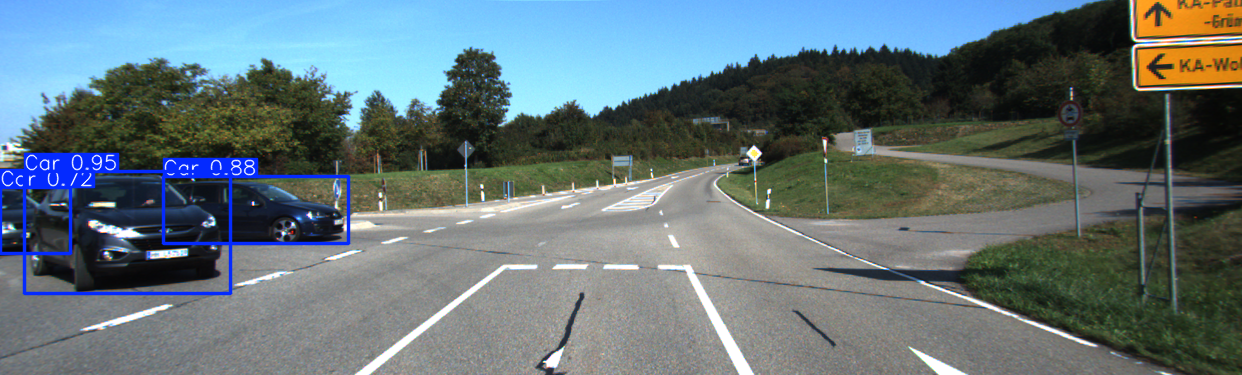

In [9]:
# Validate trained model
model.val()

# Test on a sample validation image
test_image = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000001.png"  # Replace with an actual image path

results = model(test_image)  # Returns a list of results
results[0].show()  # Show the first result

In [10]:
# Validate the model on the validation set
metrics = model.val()

# Extract mAP (Mean Average Precision)
mAP_50 = metrics.box.map50  # mAP at IoU=0.5
mAP_50_95 = metrics.box.map  # mAP at IoU=0.5:0.95

print(f"Model Accuracy (mAP@50): {mAP_50:.2f}")
print(f"Model Accuracy (mAP@50-95): {mAP_50_95:.2f}")

Ultralytics 8.3.131 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3364.7±1487.5 MB/s, size: 790.1 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  7.84it/s]


                   all       1497       7631      0.733      0.642      0.711      0.462
                   Car       1338       5693      0.818      0.848        0.9      0.652
            Pedestrian        349        873      0.676      0.495      0.573      0.282
               Cyclist        209        292      0.633      0.585      0.601      0.301
                 Truck        208        220      0.818      0.745      0.835      0.618
                   Van        421        553      0.718      0.538      0.646      0.455


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train23
Model Accuracy (mAP@50): 0.71
Model Accuracy (mAP@50-95): 0.46
